## Estudiante a cargo de la creación del extra: Efraín Retana Segura, grupo 2 de las 10 de la mañana


## 1. Prologo

### Como bien hable con el profesor, este es una nueva creación del extra del anexo de la investigación, donde se pide un clasificador de modelo

### En el anterior creado lo hice usando CNN ( a causa de esto se tuvo que hacer de nuevo), donde su proposito era identificar caras tristes y felices usando Sigmoide.

### En este quiero crear un entreno de clasificador de números usando dataset de MNIST, este es un conjunto de 70 mil de dígitos manuscritos del 0 al 9 con los cuales uno tiene 60 mil para entrenar, y 10 mil para probar. Este viene integrado en la libreria Pytorch la cual vamos a usar para crear este modelo.

# 2.Librerias que se necesitan para hacer la prueba

#### Pytorch y matplotlib principalmente

### 2.1) Instalación Pytorch

In [118]:
### !pip install torch torchvision torch-geometric

#### 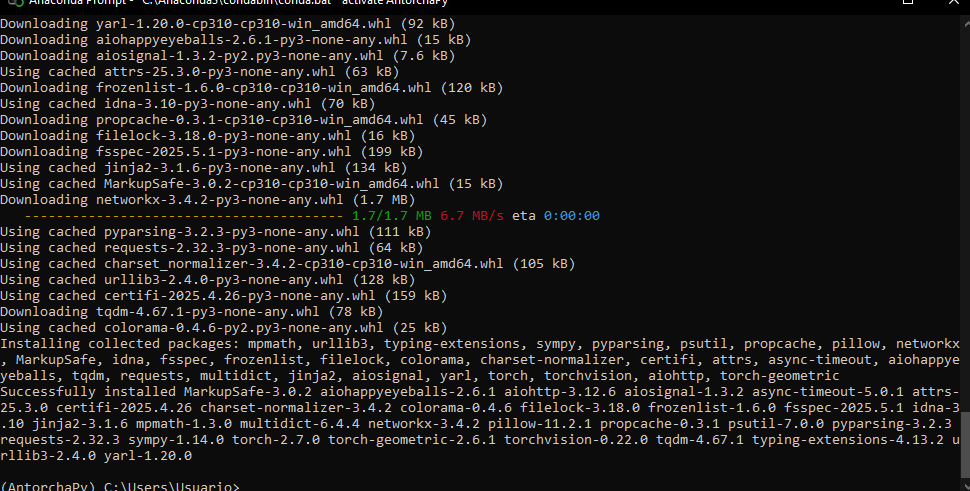

### Ahora podemos empezar con el codigo

## 3.Creación de imports y funciones (Datasets)

In [119]:
import torch
from torch.utils.data import DataLoader
from torch_geometric.data import Data
from torch_geometric.datasets.mnist_superpixels import MNISTSuperpixels

#### Vamos a cargar el dataset de MNIST, desde torch_geometrics. si train es True carga todo los datos, si es False los de validación/test.
#### MNIST Superpixeles es un versión del dataset MNIST en la que cada imagén se convierte en un grafo usando superpixeles, y cada nodo representa una región de la imagén.

In [120]:
from torch_geometric.datasets import MNISTSuperpixels

def build_mnist_superpixels_datasets(train: bool) -> MNISTSuperpixels:
    return MNISTSuperpixels(root="mnist-superpixels-dataset", train=train)


### Este metodo define una función "collate" personalizada para agrupar los grafos en cada lote de entrenamiento.

In [121]:
def build_collate_fn(device: str | torch.device):
    from torch_geometric.data import Data, Batch
    
    def collate_fn(original_batch: list[Data]):
        data_list = []
        for i, data in enumerate(original_batch):
            # Crear nuevo objeto Data con atributos necesarios
            new_data = Data(
                x=torch.cat((data.x, data.pos), dim=-1),  # Características concatenadas
                edge_index=data.edge_index,
                y=data.y,
                batch=torch.full((data.x.size(0),), i, dtype=torch.long)  # Asignar índice de grafo
            )
            data_list.append(new_data)
        
        # Crear batch y mover a dispositivo
        batch = Batch.from_data_list(data_list).to(device)
        return batch
    
    return collate_fn

#### Aqui vamos a crear un dataLoader de Pytorch para iterar sobre el dataset, en lotes.
#### Esto es importante por que maneja la entrega ordenada o si bien queremos aleatoria con shuffle, a los datos del modelo durante el entreno. 
#### Usamos el collate_fn para que cada batch tenga los grafos estructurados de forma correcta..

In [122]:
from torch.utils.data import DataLoader
from torch_geometric.datasets import MNISTSuperpixels

def build_dataloader(
    dataset: MNISTSuperpixels,
    batch_size: int,
    shuffle: bool,
    device: str | torch.device,
) -> DataLoader:
    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=build_collate_fn(device=device),
    )
    return loader


### Ahora ya hecho todo estos metodos vamos a juntarlo todo, donde vamos a cargar el dataset de entreno y validación y creremos sus respectivos DataLoaders que los va a devolver.
### Esto nos va a permitir usar train_loader, val_loader = build_train_val_dataloaders(batch_size=32, device="cuda") 


In [123]:
def build_train_val_dataloaders(batch_size: int, device: str) -> tuple[DataLoader, DataLoader]:
    train_dataset = build_mnist_superpixels_datasets(train=True)
    val_dataset = build_mnist_superpixels_datasets(train=False)

    train_loader = build_dataloader(train_dataset, batch_size=batch_size, shuffle=True, device=device)
    val_loader = build_dataloader(val_dataset, batch_size=batch_size, shuffle=False, device=device)

    return train_loader, val_loader

## 3.2 Probemos y carguemos los datasets para visualizar 

### Aqui vamos a tener que usar a nuestro viejo conocido matplotlib y networkx 

### Importamos matplotlib y networkx de la siguiente manera

In [124]:
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import networkx as nx

Label: tensor([5])
Número de nodos: 75
Dimensiones de características: torch.Size([75, 1])
Posiciones: torch.Size([75, 2])


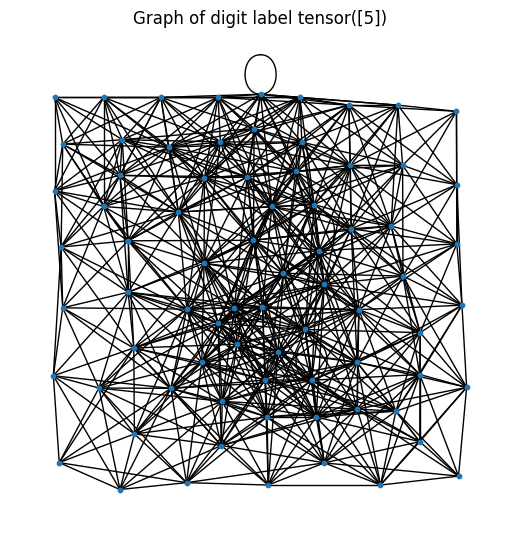

In [125]:
# Cargar un dataset y visualizar
train_dataset = build_mnist_superpixels_datasets(train=True)
data_example = train_dataset[0]

print(f"Label: {data_example.y}")
print(f"Número de nodos: {data_example.num_nodes}")
print(f"Dimensiones de características: {data_example.x.shape}")
print(f"Posiciones: {data_example.pos.shape}")

# Convertir a grafo de NetworkX para visualizar
G = to_networkx(data_example, to_undirected=True)
pos_dict = {i: pos.tolist() for i, pos in enumerate(data_example.pos)}

plt.figure(figsize=(5, 5))
nx.draw(G, pos=pos_dict, node_size=10)
plt.title(f"Graph of digit label {data_example.y}")
plt.show()


### Observemos que este es el grafo que se nos crea con nuestro dataset, con esto vamos a trabajar para crear el modelo y al final dar con la prueba del modelo.

## 4. Creación del modelo  

### Vamos a crear el modelo GATConv para que aprendan las representaciones de los nodos, esta concatena las salidas de varias etapas para capturar
### diferentes niveles de abstracción, realiza un readout por promedio de todo los nodos del grafo( la imagen) y lo pasa por un clasificador denso(self.fc)
### Esta predice la clase del digito (0-9) para cada grafo que representa una imagen del MNIST Superpixeles.
#### NOTA. El GATConv es una capa de pytorch Geometric que permite a cada nodo en un grafo aprender a "entender" a sus vecinos importantes, mediante un mecanismo de atención, en lugar de simplemente promediar o sumar las caracteristicas de sus vecinos como en GCN.

### Importaremos lo siguiente

In [126]:
import torch
from torch import nn
from torch_geometric.nn import GATConv 

### Metodos y clase

#### Modelo GNN para clasificación de imágenes representadas como grafos.
#### Usa tres capas GAT para procesar características de nodos y sus conexiones.
#### Combina las salidas de las capas con las características iniciales y 
#### aplica un clasificador final para predecir la clase de cada grafo en el batch.

In [127]:
import torch
import torch.nn as nn
from torch_geometric.nn import GATConv, global_mean_pool, global_max_pool

class GNNImageClassificator(nn.Module):
    def __init__(self, in_channels: int = 3, hidden_dim: int = 152, num_classes: int = 10):
        super().__init__()
        self.in_channels = in_channels
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        
        # Capas de atención
        self.conv1 = GATConv(in_channels=in_channels, out_channels=hidden_dim)
        self.conv2 = GATConv(in_channels=hidden_dim, out_channels=hidden_dim)
        self.conv3 = GATConv(in_channels=in_channels + hidden_dim, out_channels=hidden_dim)
        
        # Nuevo tamaño total de características luego de concatenar: x0 + x1 + x2 + x3
        self.total_feat_dim = in_channels + 3 * hidden_dim
        self.readout_dim = self.total_feat_dim * 2  # mean + max pooling
        
        # Clasificador
        self.fc = nn.Sequential(
            nn.Linear(self.readout_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 64),
            nn.ReLU(True),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, data):
        """
        data debe ser un objeto `Batch` de PyG con atributos:
        - x: [N, in_channels] (aquí in_channels debería ser 3)
        - pos: [N, 2], posiciones de los nodos
        - edge_index: [2, E]
        - batch: [N], que indica a qué grafo pertenece cada nodo
        """
        x0 = torch.cat([data.x, data.pos], dim=-1)  # concatena características y posiciones: [N, 3]
        print(f"x0 shape después de concatenar: {x0.shape}")  #
    
        edge_index = data.edge_index
        batch = data.batch  # necesario para pooling por grafo
    
        x1 = self.conv1(x0, edge_index)
        x2 = self.conv2(x1, edge_index)
        x0_x2 = torch.cat((x0, x2), dim=-1)
        x3 = self.conv3(x0_x2, edge_index)
    
        x_all = torch.cat((x0, x1, x2, x3), dim=-1)
    
        # Readout por grafo (mean + max pooling)
        x_mean = global_mean_pool(x_all, batch)
        x_max = global_max_pool(x_all, batch)
        x_readout = torch.cat((x_mean, x_max), dim=-1)  # [batch_size, readout_dim]
    
        return self.fc(x_readout)

## 5. Entrenamiento del modelo

### Una vez hecho el modelo vamos a entrenarlo, este va a entrenar a partir de las imagenes convertidas en grafos usando los superpixeles.


#### Vamos a necesitar los siguientes imports

In [128]:
from typing import Callable, cast  # Herramientas para anotaciones de tipos y conversiones explícitas de tipos en Python

import click  # Librería para crear interfaces de línea de comandos fácilmente
import torch  # Principal librería de PyTorch para tensores y computación en GPU/CPU
import wandb  # Weights & Biases: para registrar métricas y visualizar resultados de entrenamiento


#### Entrena el modelo durante una época completa.
#### Para cada batch en el conjunto de entrenamiento:
####   - Obtiene características y etiquetas.
####   - Calcula la predicción y la pérdida.
####  - Realiza propagación hacia atrás y actualiza los pesos.
####   - Calcula y registra la precisión y pérdida en wandb.
#### Devuelve el número total de batches procesados hasta ahora.


In [129]:
def train_one_epoch(
    model: GNNImageClassificator,
    optimizer: torch.optim.Optimizer,
    train_loader: DataLoader,
    criterion: Callable,
    batches_passed: int,
) -> int:
    """
    Entrena el modelo durante una época con batches de grafos.
    """
    model.train()
    device = next(model.parameters()).device  # Detecta si está en CPU o GPU

    for batch in train_loader:
        batch = batch.to(device)  # Mueve batch al dispositivo correcto

        # Salida del modelo
        logits = model(batch)  # batch.x, batch.edge_index, batch.batch

        # Pérdida y backpropagation
        loss = criterion(logits, batch.y).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Métrica de accuracy
        predicted_classes = torch.argmax(logits, dim=1)
        accuracy = (predicted_classes == batch.y).float().mean()

        wandb.log({
            "train_accuracy": accuracy.item(),
            "train_loss": loss.item(),
            "batch": batches_passed,
        })

        batches_passed += 1

    return batches_passed


#### Evalúa el modelo en el conjunto de validación sin modificar pesos.
#### Para cada batch( o lote como se le quiera decir), calcula la precisión de predicción.
#### Acumula la precisión ponderada por el tamaño del batch.
#### Al final, calcula la precisión promedio total.
#### Registra la métrica de precisión en wandb para seguimiento.


In [130]:
def evaluate(model, val_loader, epochs_passed):
    model.eval()
    accuracy_sum = 0.0
    num_samples = 0

    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(next(model.parameters()).device)  # mover a device si quieres
            logits = model(batch)  # pasar el batch completo

            predicted_classes = torch.argmax(logits, dim=1)
            accuracy_sum += float((predicted_classes == batch.y).float().mean().cpu().numpy()) * len(batch.y)
            num_samples += len(batch.y)

    accuracy = accuracy_sum / num_samples

    wandb.log({
        "val_accuracy": accuracy,
        "epoch": epochs_passed,
    })



#### Función principal de entrenamiento del modelo GNN.
#### - Configura wandb para seguimiento de métricas.
#### - Inicializa el modelo, dataloaders y optimizador.
#### - Muestra imágenes de ejemplo del dataset para visualización.
#### - Por cada época, entrena el modelo (train_one_epoch) y lo evalúa (evaluate).
#### - Registra métricas de precisión y pérdida para entrenamiento y validación.

In [131]:
from torch_geometric.datasets import MNISTSuperpixels

def get_dataset_info() -> int:
    """
    Muestra información detallada del dataset y retorna la dimensión de entrada (features por nodo).
    """
    dataset = MNISTSuperpixels(root="./data", train=True)
    sample = dataset[0]

    x = sample.x                     # Características por nodo
    pos = sample.pos                # Coordenadas 2D del nodo
    edge_index = sample.edge_index  # Aristas
    y = sample.y                    # Etiqueta

    # Concatenación típica: características + posición
    x_pos = torch.cat([x, pos], dim=1)

    print("=== Información del Dataset ===")
    print(f"Características del nodo (x): {x.shape}")
    print(f"Posiciones (pos): {pos.shape}")
    print(f"Dimensiones concatenadas: {x_pos.shape}")
    print(f"Número de nodos: {x.shape[0]}")
    print(f"Aristas: {edge_index.shape}")
    print(f"Etiqueta: {y}")
    print(f"Dimensiones de entrada correctas: {x_pos.shape[1]}")
    
    return x_pos.shape[1]

In [132]:
get_dataset_info()

=== Información del Dataset ===
Características del nodo (x): torch.Size([75, 1])
Posiciones (pos): torch.Size([75, 2])
Dimensiones concatenadas: torch.Size([75, 3])
Número de nodos: 75
Aristas: torch.Size([2, 1399])
Etiqueta: tensor([5])
Dimensiones de entrada correctas: 3


3

In [133]:
import wandb
from typing import cast
from torch_geometric.datasets import MNISTSuperpixels
import torch.optim

def train(
    batch_size: int = 64,
    epochs: int = 100,
    device: str = "cpu",
    hidden_dim: int = 152,
    lr: float = 1e-3
) -> None:
    """
    Controlador principal del entrenamiento con verificación de dimensiones.
    """
    # Obtener las dimensiones correctas del dataset
    input_dim = get_dataset_info()
    
    wandb.init(project="mnist-superpixels-gnn-classification")
    wandb.config.update({
        "batch_size": batch_size,
        "epochs": epochs,
        "device": device,
        "hidden_dim": hidden_dim,
        "lr": lr,
        "input_dim": input_dim
    })

    wandb.define_metric("batch")
    wandb.define_metric("epoch")
    wandb.define_metric("train_accuracy", step_metric="batch")
    wandb.define_metric("train_loss", step_metric="batch")
    wandb.define_metric("val_accuracy", step_metric="epoch")

    # Usar las dimensiones correctas
    model = GNNImageClassificator(in_channels=input_dim, hidden_dim=hidden_dim).to(device)
    train_loader, val_loader = build_train_val_dataloaders(batch_size=batch_size, device=device)
    optimizer = torch.optim.Adam(lr=lr, params=model.parameters())

    # Visualización de ejemplos (opcional, comentar si causa problemas)
    try:
        visualize(cast(MNISTSuperpixels, train_loader.dataset), image_name="all_classes.jpg")
        visualize(cast(MNISTSuperpixels, train_loader.dataset), image_name="one_class.jpg", classes=(4,), examples_per_class=1)
        wandb.log({"sample_images": [wandb.Image("all_classes.jpg"), wandb.Image("one_class.jpg")]})
    except Exception as e:
        print(f"Error en visualización: {e}")

    batches_passed = 0
    for epoch_ix in range(epochs):
        print(f"Época {epoch_ix + 1}/{epochs}")
        batches_passed = train_one_epoch(model, optimizer, train_loader, torch.nn.CrossEntropyLoss(), batches_passed)
        evaluate(model, val_loader, epochs_passed=epoch_ix + 1)

    # Guardar el modelo entrenado
    torch.save(model.state_dict(), "modelo_gnn_mnist.pth")
    print("Modelo guardado como 'modelo_gnn_mnist.pth'")



## 6. Una vez creada el entrenamiento del modelo podemos comenzar a generar las visualizaciones y como de precisa tiene este modelo al frente de su clasificacion de numeros

### Para lo ultimo vamos a necesitar estos siguientes y ultimos!!

In [134]:
import cv2
import numpy as np
import torch_geometric
from matplotlib import pyplot as plt
from torch_geometric.datasets import MNISTSuperpixels



#### Convierte una muestra de superpíxeles en formato de grafo a una imagen 2D en escala de grises.
#### - Escala las posiciones de los nodos para visualización.
#### - Dibuja cada superpíxel como un rectángulo en base a su posición y valor.
#### - Dibuja las conexiones entre nodos (bordes) como líneas.
#### - Retorna una imagen NumPy (matriz 2D con canales) lista para mostrar o guardar.


In [135]:
import numpy as np
def superpixels_to_2d_image(rec: Data, scale: int = 30, edge_width: int = 1) -> np.ndarray:
    """
    Convierte datos de superpíxeles a imagen 2D con validación de límites.
    """
    pos = (rec.pos.clone() * scale).int()
    
    # Crear imagen con dimensiones seguras
    img_size = scale * 26
    image = np.zeros((img_size, img_size, 1), dtype=np.uint8)
    
    # Dibujar superpíxeles con validación de límites
    for (color, (x, y)) in zip(rec.x, pos):
        x0, y0 = int(x), int(y)
        x1, y1 = x0 + scale, y0 + scale
        
        # Validar límites
        x0 = max(0, min(x0, img_size - 1))
        y0 = max(0, min(y0, img_size - 1))
        x1 = max(0, min(x1, img_size - 1))
        y1 = max(0, min(y1, img_size - 1))
        
        if x1 > x0 and y1 > y0:  # Solo dibujar si hay área válida
            color_val = int(float(color + 0.15) * 255)
            color_val = min(max(color_val, 0), 255)
            cv2.rectangle(image, (x0, y0), (x1, y1), color_val, -1)

    # Dibujar aristas con validación
    for node_ix_0, node_ix_1 in rec.edge_index.T:
        if node_ix_0 < len(pos) and node_ix_1 < len(pos):
            x0, y0 = list(map(int, pos[node_ix_0]))
            x1, y1 = list(map(int, pos[node_ix_1]))

            # Centrar en el superpíxel
            x0 += scale // 2
            y0 += scale // 2
            x1 += scale // 2
            y1 += scale // 2

            # Validar límites
            x0 = max(0, min(x0, img_size - 1))
            y0 = max(0, min(y0, img_size - 1))
            x1 = max(0, min(x1, img_size - 1))
            y1 = max(0, min(y1, img_size - 1))

            cv2.line(image, (x0, y0), (x1, y1), 125, edge_width)
            
    return image

#### Visualiza ejemplos de imágenes generadas a partir de superpíxeles por clase.
#### - Toma un dataset (MNISTSuperpixels) y genera imágenes por clase usando superpixels_to_2d_image.
#### - Organiza las imágenes en una cuadrícula usando matplotlib.
#### - Guarda la imagen resultante en disco con el nombre especificado.
#### - Muestra la figura directamente en el notebook.

In [136]:
def visualize(
    dataset: MNISTSuperpixels,
    image_name: str,
    examples_per_class: int = 10,
    classes: tuple[int, ...] = tuple(range(10)),
    figsize: tuple[int, int] = (50, 50),
    edge_width: int = 1,
) -> None:
    class_to_examples = {class_ix: [] for class_ix in classes}

    for record in dataset:
        enough = all(len(examples) >= examples_per_class for examples in class_to_examples.values())
        if enough:
            break

        class_ix = int(record.y)

        if class_ix not in class_to_examples:
            continue

        if len(class_to_examples[class_ix]) >= examples_per_class:
            continue

        class_to_examples[class_ix].append(superpixels_to_2d_image(record, edge_width=edge_width))

    plt.figure(figsize=figsize)
    subplot_ix = 1
    for class_ix in classes:
        for example in class_to_examples[class_ix]:
            plt.subplot(len(classes), examples_per_class, subplot_ix)
            subplot_ix += 1
            plt.imshow(example, cmap=plt.cm.binary)
            plt.axis("off")

    plt.tight_layout()
    plt.savefig(image_name)
    plt.show()  # Mostrar en el notebook

In [137]:
def visualize_dataset_example():
    """
    Visualiza un ejemplo del dataset para entender la estructura.
    """
    train_dataset = build_mnist_superpixels_datasets(train=True)
    data_example = train_dataset[0]

    print(f"Label: {data_example.y}")
    print(f"Número de nodos: {data_example.num_nodes}")
    print(f"Dimensiones de características: {data_example.x.shape}")
    print(f"Posiciones: {data_example.pos.shape}")

    # Convertir a grafo de NetworkX para visualizar
    G = to_networkx(data_example, to_undirected=True)
    pos_dict = {i: pos.tolist() for i, pos in enumerate(data_example.pos)}

    plt.figure(figsize=(5, 5))
    nx.draw(G, pos=pos_dict, node_size=10)
    plt.title(f"Graph of digit label {data_example.y}")
    plt.show()


Label: tensor([5])
Número de nodos: 75
Dimensiones de características: torch.Size([75, 1])
Posiciones: torch.Size([75, 2])


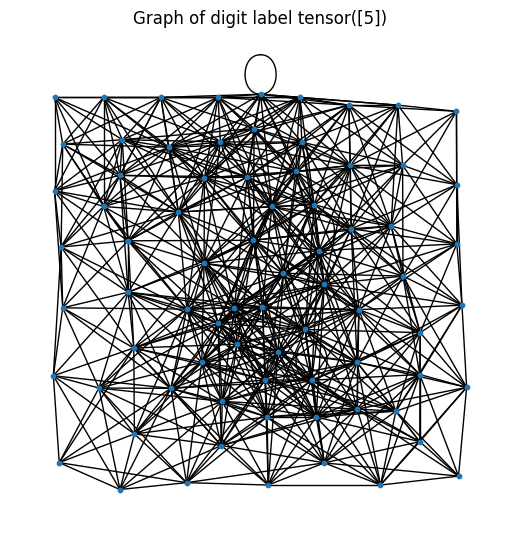

In [138]:
visualize_dataset_example()

#### Carga los conjuntos de datos MNISTSuperpixels para entrenamiento y prueba.
#### Luego, visualiza:
#### - Un subconjunto de ejemplos (5 por clase) para todas las clases del 0 al 9.
#### - Un único ejemplo específico de la clase 4.
#### Las imágenes se guardan en disco y se muestran directamente en el notebook.

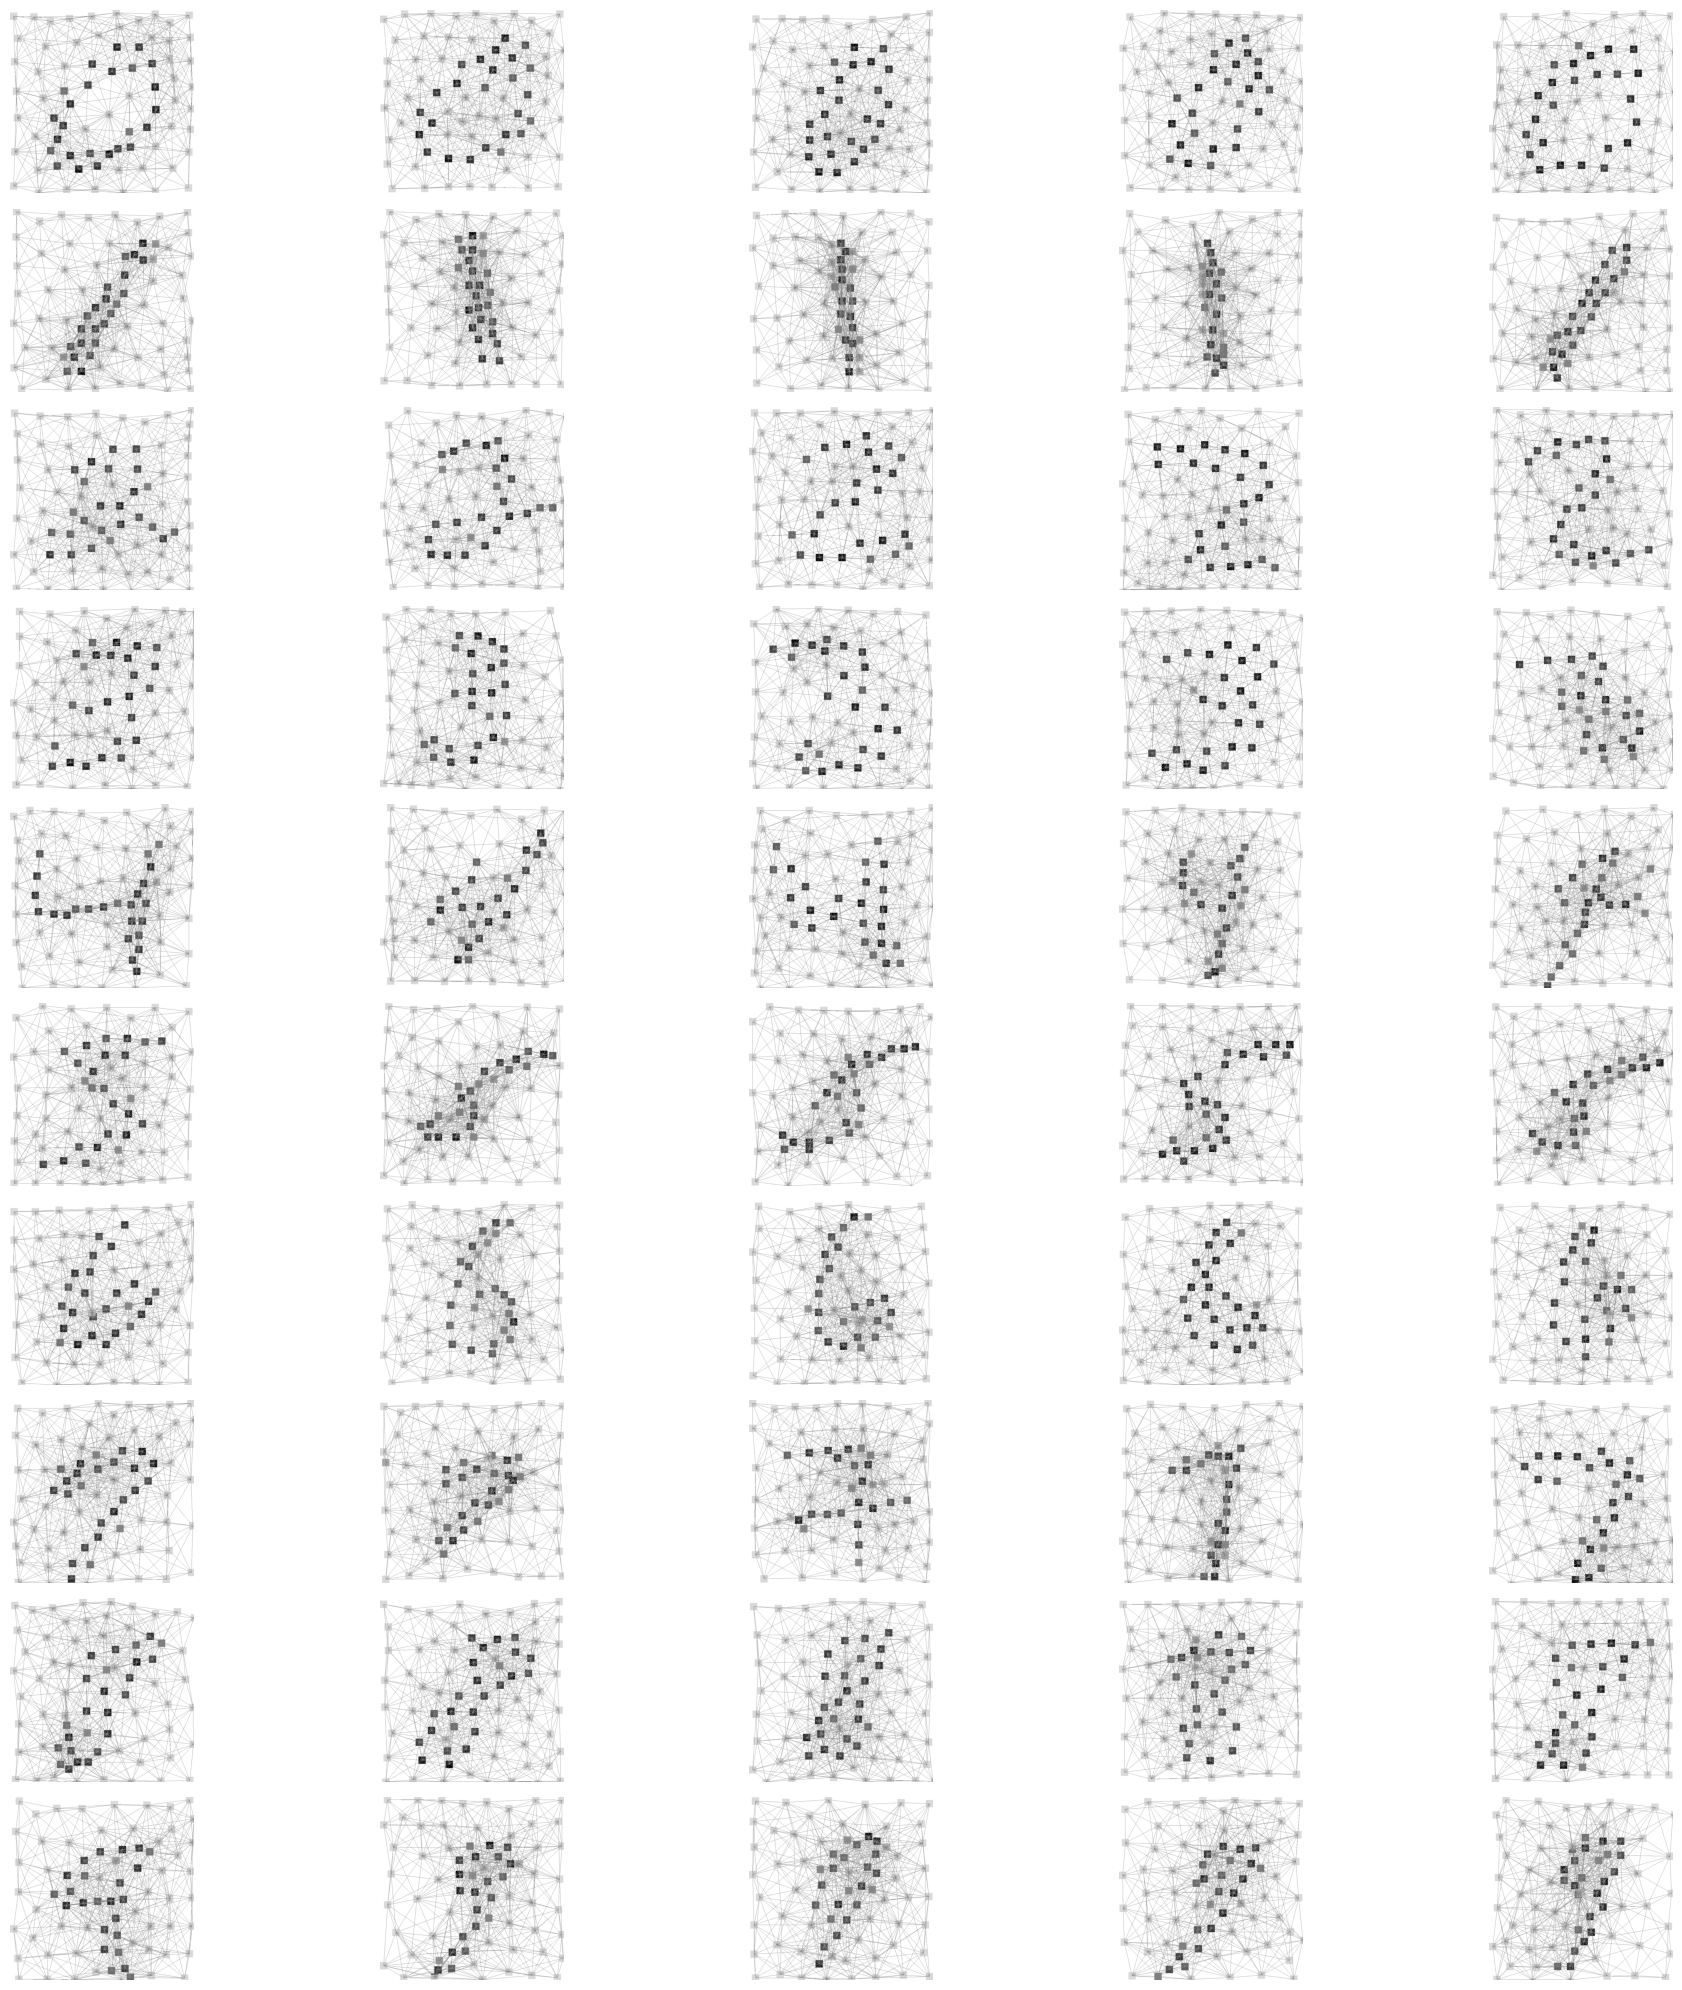

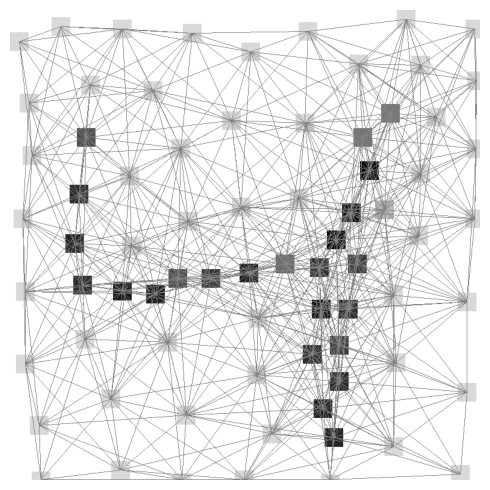

In [139]:
# Cargar los datos de entrenamiento y prueba
train_dataset = build_mnist_superpixels_datasets(train=True)
test_dataset = build_mnist_superpixels_datasets(train=False)

# Visualizar todos los dígitos
visualize(
    train_dataset,
    image_name="all_classes.jpg",
    examples_per_class=5,  # puedes cambiar a 10 si quieres más ejemplos
    figsize=(20, 20)
)

# Visualizar un solo ejemplo de la clase 4
visualize(
    train_dataset,
    image_name="one_class.jpg",
    classes=(4,),
    examples_per_class=1,
    figsize=(5, 5)
)

In [248]:
# train(batch_size=64, epochs=20, device="cpu", hidden_dim=152, lr=1e-3)


### Comente esta parte debido a que tuve que abrir otra vez el notebook, y ya habia hecho entrenos y tenia guardado el modelo, entonces volver a llamar esta linea, no tendría sentido, se vería algo parecido a esto
##### 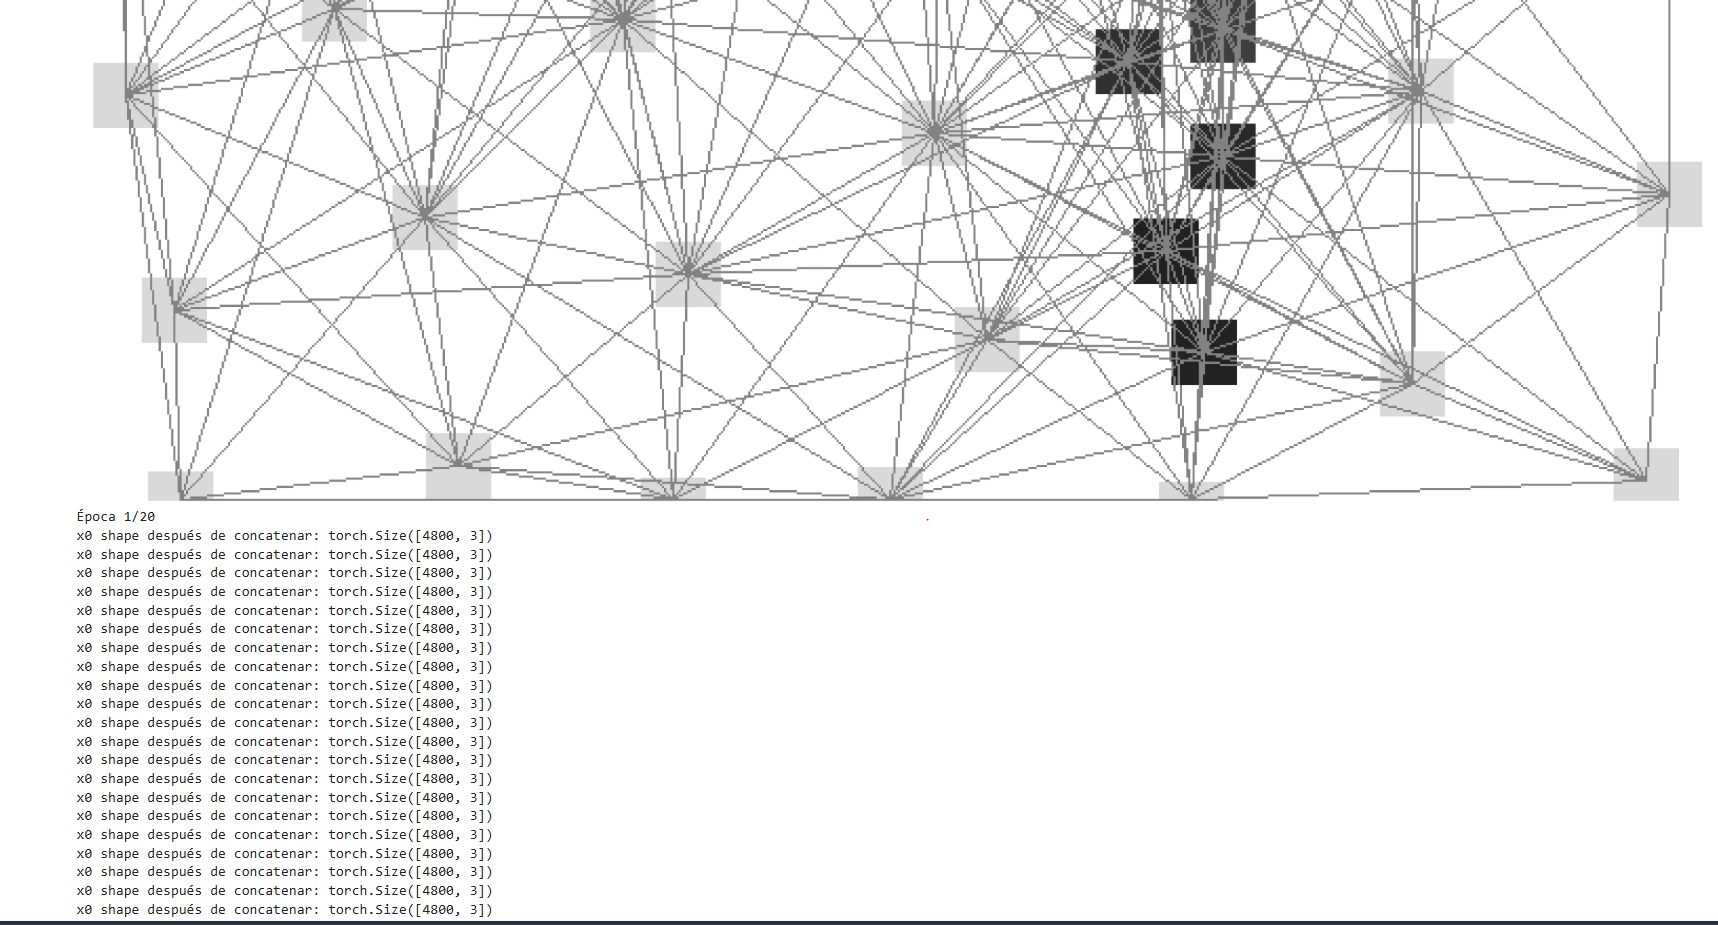
### Donde se muestra una columna y fila de números y de este se usa una referencia, para que el modelo se entrene con este, y le puse por que época pasaba y la verificación de concatenación, con esto se puede asegurar que esta funcionando bien, más obvio el hecho de fijarse en la pagína como se ve el progreso de nuestro modelo, esto al final le sale los resultados en las graficas y le enseña hasta que punto aprendió.

### Visualizacición de entreno del modelo, observemos que la perdida del modelo va disminuyendo cosa que es positiva y su accuracy va ascendiendo lo cual podemos interpretar de un modelo que esta funcionando bien, tambien el val_accuracy, donde puede obtener caidas pero no tan significativas
### 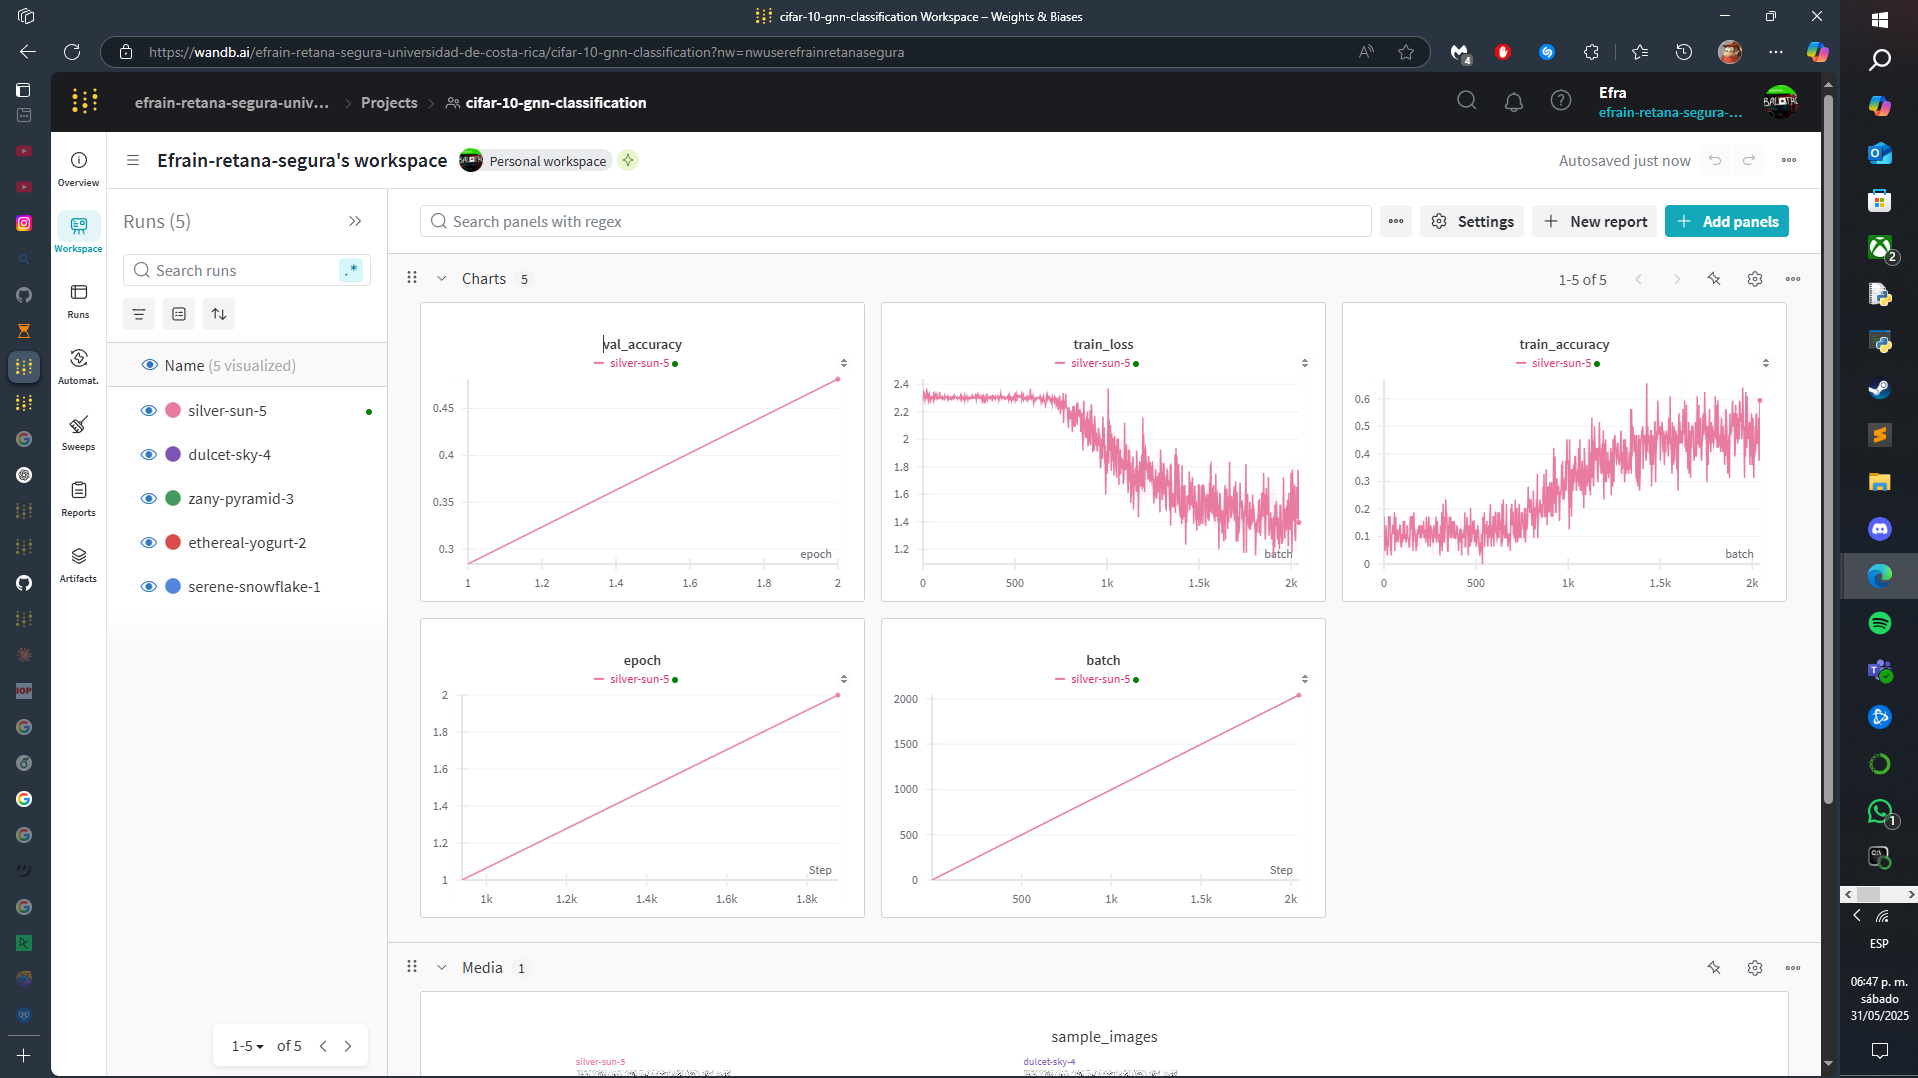

### Tuve que hacer esto como casi 30 veces, debido a que me generaron erorres graves, mediante el proceso del entreno, aquí quiero dejar ciertas cosas que puedan ayudar al lector a poder evadir estos errores....
### Primer error
### Como se puede visualizar hice la prueba unas 17 veces bajo ese nombre, donde si se aprecia con cuidado una llego, hasta las 80 o 90 epochs lo cual para hacer esta obra se tuvo que dejar mi compu toda la noche para que hiciera este trabajo arduo jajajajaja, el problema cae en que si queremos entrenar un modelo este proceso se nos haria muy tardio por lo cual recomendaria no llegar hasta 100, unas 20 como lo hice están bien y se puede ver que puede llegar a niveles aceptables de accuracy y de otras partes del modelo
### 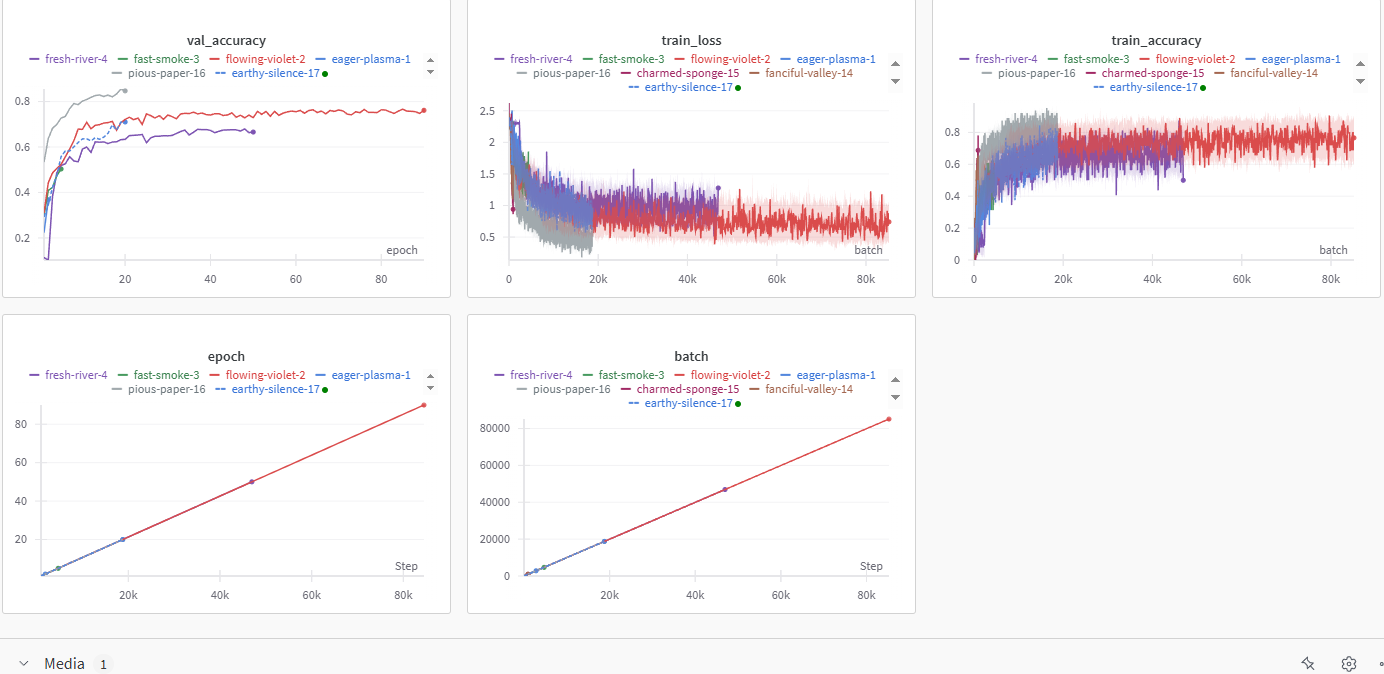
### Segundo error
### Durante esta creación tuve demasiados errores debidos a las capas de las neuronas o grafos que se pueden observar en el GNNModel y en el train, hay que tener bastante cuidado con ver que tipo de entrada necesita nuestro modelo, por ejemplo, en la parte de forward de la clase de GNN, tuve que modificarlo mil y 1 veces por que se generaban errores de aqui en adelante a la hora de intentar hacer pruebas de predicciones, lo cual es un trabajo dificil más que se tiene que ver que parte del modelo cuando se arregla cierta clase o metodo tambien se afecta, y se puede durar su ratillo, asi que recomiendo tener contemplado con que tipo de entrada o dimensiones a nuestro grafos queremos trabajar, más el hecho de cual modelo queremos usar para nuestra conveniencia como lo fue aqui usando el modelo ADAM, la que ya e usado anteriormente en la creación de un modelo CNN que me dejan resultados optimos o bastante buenos para poder ser usable en predicciones

### Aparte de estos 2 errores, recomendaria ir desinstalando basura o cosas que ya no nos sirven, debido a que usamos un dataset de 70 mil casos de 0 - 9, lo cual almacena mucho espacio, en mi caso mi computadora llego a tener esto de almacenamiento 
### 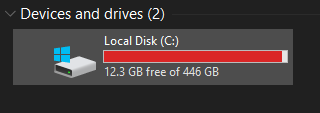
### Asi que se usa demasiado espacio para poder hacer trabajos con MNIST, aclaro que en GNN hay casos donde el consumo de data no sea tanta, pero en este caso si, también si tiene la capacidad de instalar CUDA-TOOLKITS para acelerar el proceso de entreno, se lo recomendaria bastante, ya que con una CPU de rango mediano como lo puede ser un AMD Ryzen , duro su tiempillo entrenandose

## PREDICCIONES
### Ya hablando del modelo creado, durante las diversas pruebas de entreno que le hice, llegue a la conclusión que su frecuencia de accurate esta entre los 70 y 80, con una capacidad de llegar a picos de 90 más no de 100, esto puede deberse a como construi este modelo, igualmente este rango que menciono es aceptable para poder ver como funciona sus predicciones
### Viendo nuestro ultimo entreno donde es el modelo guardado que usamos de prueba
### 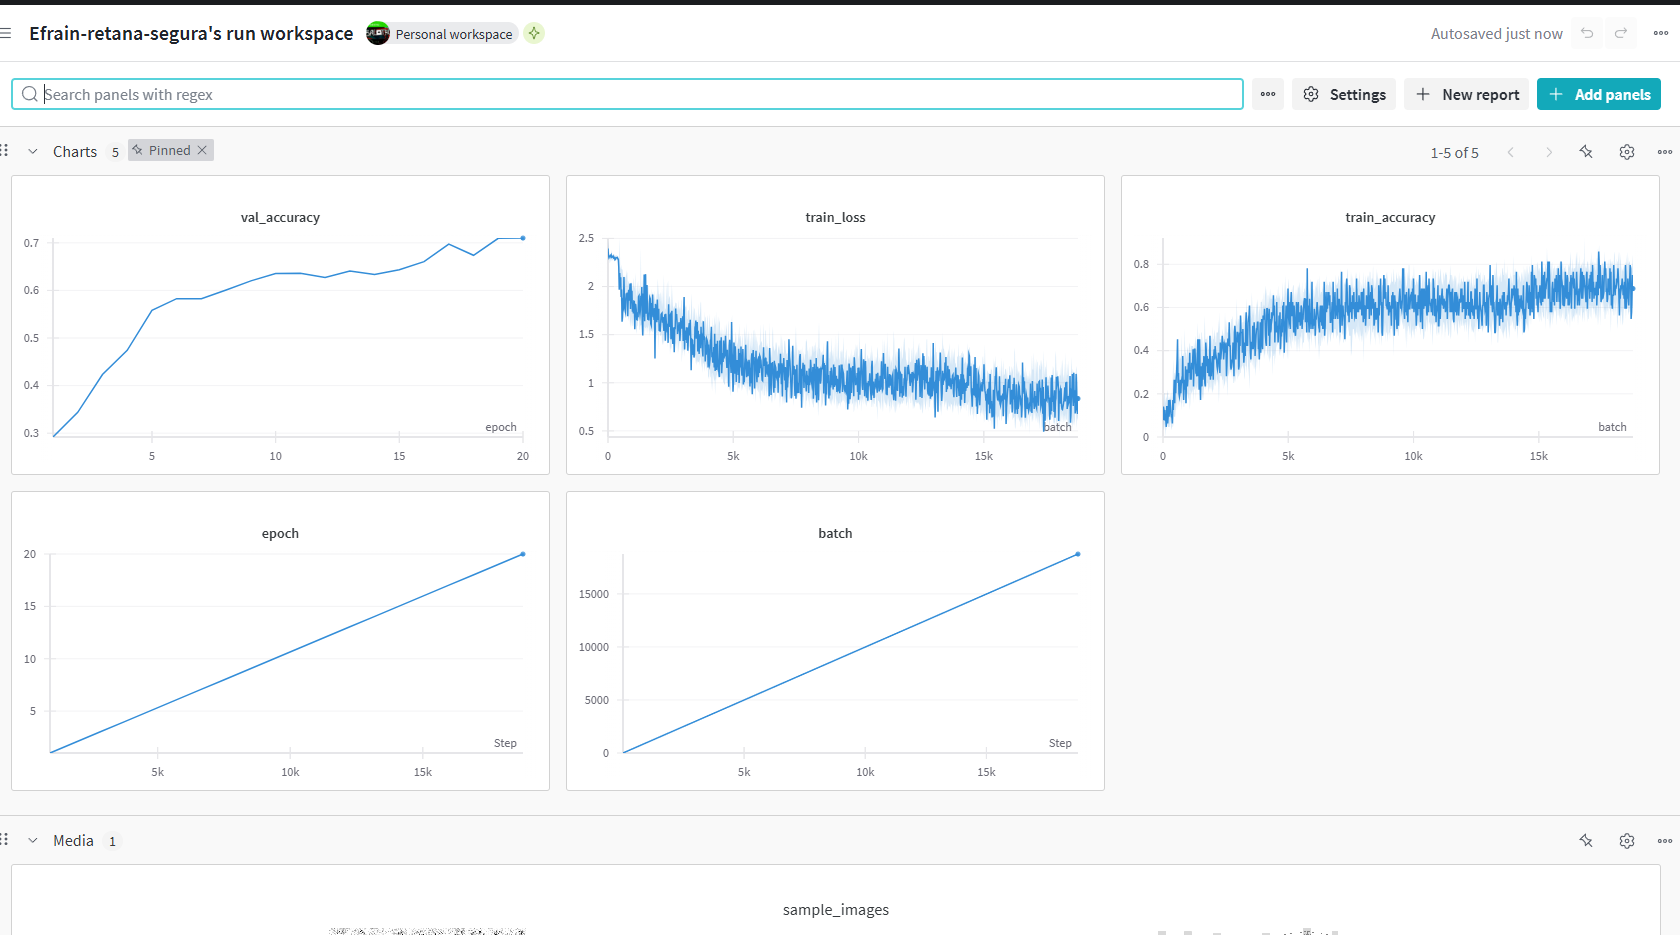
### tanto su val_accuracy y train_accuracy llegaron a su maximo de 70 - 71 los 2, lo cual se pudo mejorar con una puesta de epochs de más capacidad, pero viendo en otro ejemplo con el epoch de +80
### 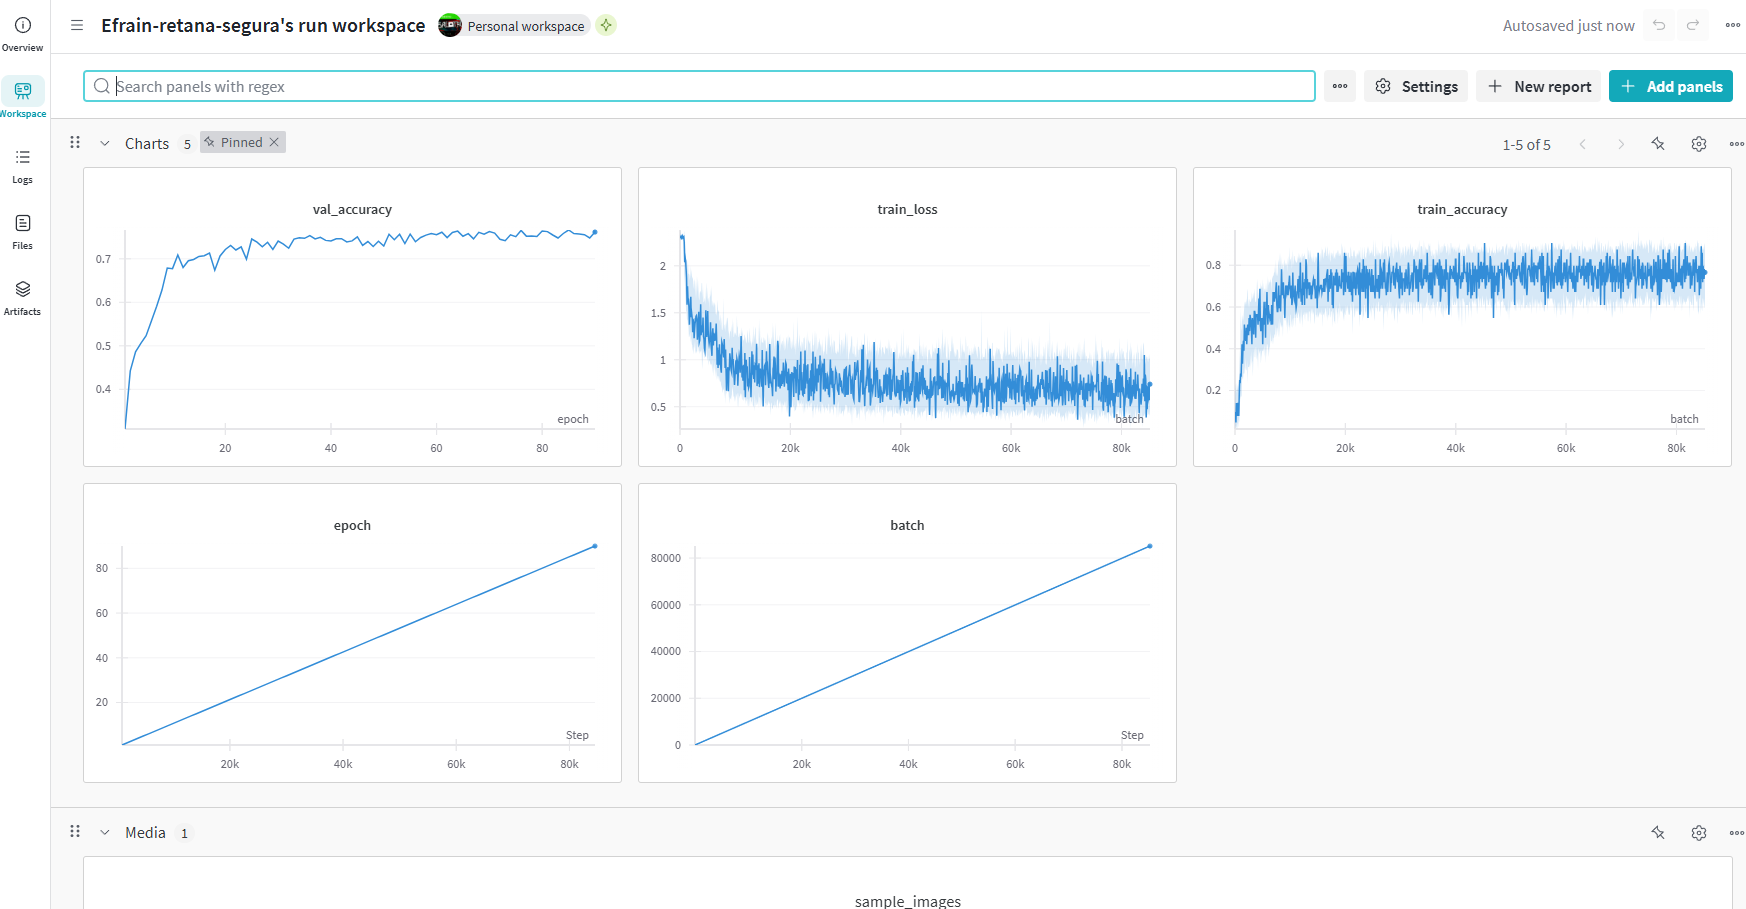 
### vemos que no hay tanta mejora, y que a pesar de tener picos buenos de accuracy en el train_accuracy se mantenia en su rango de 70-80 y ya para poder descansar mi cpu lo que hice fue usar la ultima prueba

In [141]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader


### Para poder hacer un ejemplo de predicciones, usare la propia libreria de MINST, que tiene ejemplos de pruebas para poder verificar que tan preciso es este modelo, lo cual tengo que crear un metodo que me haga esta imagen a un superpixel, donde sus metodos estan aqui abajo, aqui en la primera casilla, es donde agarro un ejemplo para que este luego se use como metodo de su imagen de origen a pasarlo a un superpixel donde el modelo pueda reconocer el grafo

In [142]:
mnist_dataset = MNIST(root=".", train=False, download=True, transform=transforms.ToTensor())
image, label = mnist_dataset[0] 

In [143]:
from skimage.segmentation import slic
from skimage.color import gray2rgb
from skimage import graph
import torch
import numpy as np
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def image_to_superpixel_graph(image_tensor: torch.Tensor, num_segments: int = 75) -> Data:
    """
    Convierte una imagen (grises o RGB) en un grafo de superpíxeles para PyG Data,
    con nodos que tienen 3 características (RGB promedio por superpíxel),
    y con posiciones de los centroides para visualización.

    image_tensor: Tensor de tamaño [3, H, W] o [1, H, W] (valores entre 0 y 1)
    """
    # Asegurar que la imagen tenga shape [H, W, 3]
    if image_tensor.dim() == 3 and image_tensor.shape[0] == 3:
        image_np = image_tensor.permute(1, 2, 0).numpy()
    elif image_tensor.dim() == 3 and image_tensor.shape[0] == 1:
        # imagen en escala de grises, convertir a RGB duplicando canales
        gray_np = image_tensor.squeeze(0).numpy()
        image_np = np.stack([gray_np]*3, axis=-1)
    else:
        raise ValueError("Formato de imagen no soportado")

    # Normalizar a [0, 1] si no está
    if image_np.max() > 1.0:
        image_np = image_np / 255.0

    # Segmentación SLIC
    segments = slic(image_np, n_segments=num_segments, compactness=10, sigma=1, start_label=0)

    # Construcción del grafo de regiones
    rag = graph.rag_mean_color(image_np, segments)

    num_nodes = len(np.unique(segments))
    node_feats = []
    positions = []

    for i in range(num_nodes):
        mask = segments == i
        # Promedio RGB por superpíxel (3 características)
        mean_rgb = image_np[mask].mean(axis=0)
        node_feats.append(mean_rgb.tolist())

        # Centroides normalizados (x, y)
        y_coords, x_coords = np.where(mask)
        centroid_x = x_coords.mean() / image_np.shape[1]
        centroid_y = y_coords.mean() / image_np.shape[0]
        positions.append([centroid_x, centroid_y])

    # Aristas bidireccionales
    edge_index = []
    for n1, n2 in rag.edges:
        edge_index.append([n1, n2])
        edge_index.append([n2, n1])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    x = torch.tensor(node_feats, dtype=torch.float)
    pos = torch.tensor(positions, dtype=torch.float)

    return Data(x=x, edge_index=edge_index, pos=pos)


### Ya antes de la prueba, probe que si estuviera sus dimensiones correctas y que lo que hice anterior de estos metodos estuvieran alineados a lo que creare aqui

In [144]:
from torchvision.datasets import MNIST
from torchvision import transforms

mnist_dataset = MNIST(root=".", train=False, download=True, transform=transforms.ToTensor())
image_tensor, label = mnist_dataset[0]

data = image_to_superpixel_graph(image_tensor, num_segments=75)
print(data.x.shape)  # Debería ser [75, 3] aproximadamente

torch.Size([69, 3])


### Aqui ya llegamos a lo que venimos, aqui lo que hice fue llamar a un sample la cual agarra una posicion que yo le pongo, adapto la imagen al formato de mi modelo, y despues creo la predicción viendo con la etiqueta real y su predicción

In [150]:
from torch_geometric.data import Batch
import torch.nn.functional as F
import torch

# Obtener una imagen y etiqueta del dataset
sample = test_dataset[0]
data = sample  # `data` es un objeto Data de PyG con .x, .pos, .edge_index, .y

# Asegurarse de que .x tenga solo las características que el modelo espera (RGB)
data.x = data.x[:, :3]  # shape [N, 3], descartamos posiciones si están incluidas

# Convertimos a Batch de 1 solo grafo
batch = Batch.from_data_list([data])

# Cargar el modelo
model = GNNImageClassificator(hidden_dim=152)
model.load_state_dict(torch.load('modelo_gnn_mnist.pth'))
model.eval()

# Inferencia con confianza
with torch.no_grad():
    output = model(batch)                     # logits
    probs = F.softmax(output, dim=1)[0]       # vector de probabilidades
    pred = probs.argmax().item()              # clase predicha
    confidence = probs[pred].item() * 100     # confianza en porcentaje

# Mostrar resultado
print(f"Etiqueta real: {data.y.item()}")
print(f"Predicción: {pred} (confianza: {confidence:.2f}%)")



x0 shape después de concatenar: torch.Size([75, 3])
Etiqueta real: 7
Predicción: 7 (confianza: 92.85%)


### ¡ Y tenemos nuestra primera predicción acertada! Ahora con esto no podemos concluir nada. ya que recordemos que este esta hecho con un 70 de accuracy lo cual en el siguiente ejemplo se podria ver reflejado ese porcentaje de entreno 

### Con el siguiente ejemplo, quiero enseñar como se ve nuestra imagen y su grafo de representación la cual agarra nuestro modelo para poder predecir el número, usare pyplot para enseñar el número

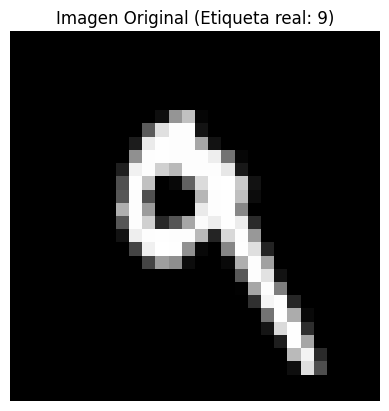

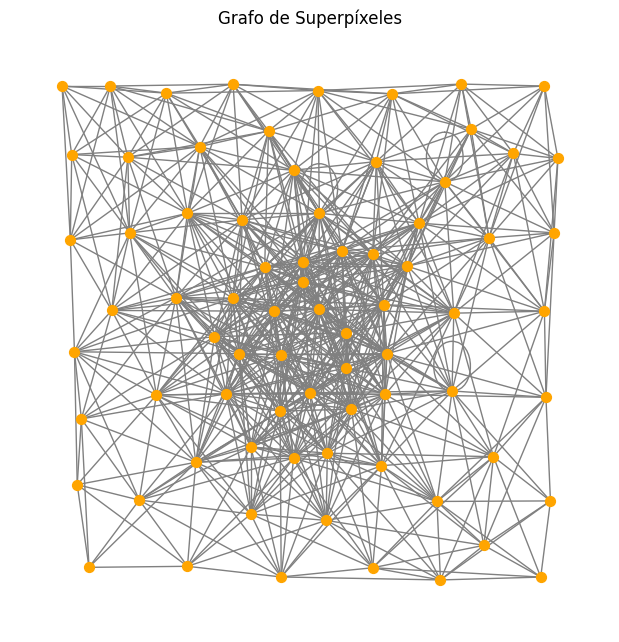

x0 shape después de concatenar: torch.Size([75, 3])
Etiqueta real: 9
Predicción del modelo: 8 (confianza: 37.96%)


In [151]:
import torch
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx
from torch_geometric.data import Batch
from torchvision.datasets import MNIST
from torchvision import transforms

# Asegúrate de que esta clase esté definida o importada correctamente
# from tu_script_modelo import GNNImageClassificator

# Dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === 1. Cargar modelo ya entrenado ===
model = GNNImageClassificator(hidden_dim=152)
model.load_state_dict(torch.load('modelo_gnn_mnist.pth', map_location=device))
model.to(device)
model.eval()

# === 2. Seleccionar imagen del dataset ===
index = 7
mnist_raw = MNIST(root=".", train=False, transform=transforms.ToTensor())
image_tensor, label = mnist_raw[index]

# Mostrar imagen original
plt.imshow(image_tensor.squeeze(0), cmap="gray")
plt.title(f"Imagen Original (Etiqueta real: {label})")
plt.axis("off")
plt.show()

# === 3. Procesar grafo de superpíxeles ===
data = test_dataset[index]

# Visualizar grafo
G = to_networkx(data, to_undirected=True)
pos = {i: data.pos[i].numpy() for i in range(data.num_nodes)}

plt.figure(figsize=(6,6))
nx.draw(G, pos, node_size=50, node_color='orange', edge_color='gray')
plt.title("Grafo de Superpíxeles")
plt.axis("off")
plt.show()

# === 4. Preparar entrada al modelo ===
data.x = data.x[:, :3]  # solo RGB
data = data.to(device)
batch = Batch.from_data_list([data])

# === 5. Predicción ===
with torch.no_grad():
    output = model(batch)
    pred = output.argmax(dim=1).item()
    probs = torch.nn.functional.softmax(output, dim=1)
    confidence = probs[0, pred].item() * 100

# === 6. Mostrar resultado ===
print(f"Etiqueta real: {label}")
print(f"Predicción del modelo: {pred} (confianza: {confidence:.2f}%)")


### Y aqui tenemos nuestro primer fallo, como mencione anteriormente su problema de no ser tan accurate eran estos, donde a pesar de que estemos cerca del número que se muestra, no es el número...

### Como ultimo ejemplo veamos si tendremos una prueba de predict exitosa o una que este cerca pero no lo es

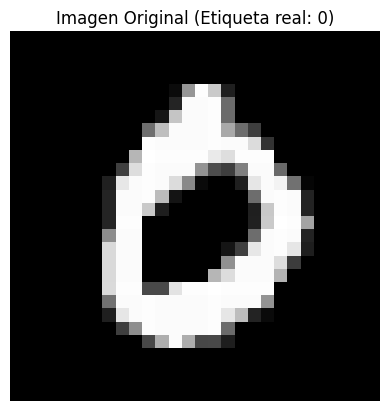

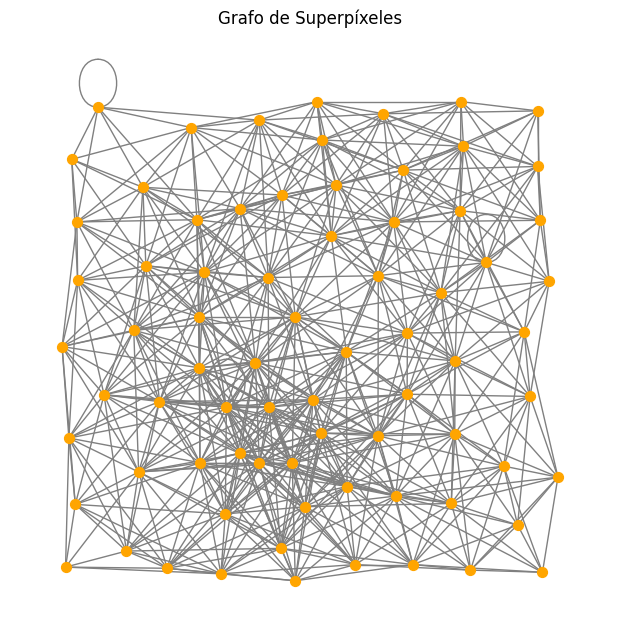

x0 shape después de concatenar: torch.Size([75, 3])
Etiqueta real: 0
Predicción del modelo: 0 (confianza: 72.28%)


In [152]:
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn.functional as F
from torch_geometric.utils import to_networkx
from torch_geometric.data import Batch
from torchvision.datasets import MNIST
from torchvision import transforms

# --- Parámetros ---
index = 3

# --- Cargar imagen original desde MNIST sin procesar ---
mnist_raw = MNIST(root=".", train=False, transform=transforms.ToTensor())
image_tensor, label = mnist_raw[index]

# Mostrar imagen original
plt.imshow(image_tensor.squeeze(0), cmap="gray")
plt.title(f"Imagen Original (Etiqueta real: {label})")
plt.axis("off")
plt.show()

# --- Obtener el grafo correspondiente desde test_dataset ---
data = test_dataset[index]

# Asegurarse de que .x tenga solo las características esperadas (RGB)
data.x = data.x[:, :3]

# --- Graficar el grafo de superpíxeles ---
G = to_networkx(data, to_undirected=True)
pos = {i: data.pos[i].numpy() for i in range(data.num_nodes)}

plt.figure(figsize=(6, 6))
nx.draw(G, pos, node_size=50, node_color='orange', edge_color='gray')
plt.title("Grafo de Superpíxeles")
plt.axis("off")
plt.show()

# --- Crear el batch y hacer predicción ---
batch = Batch.from_data_list([data])

# Asegurarse de que el modelo esté definido y cargado
model = GNNImageClassificator(hidden_dim=152)
model.load_state_dict(torch.load("modelo_gnn_mnist.pth"))
model.eval()

# Inferencia
with torch.no_grad():
    output = model(batch)
    probs = F.softmax(output, dim=1)[0]
    pred = probs.argmax().item()
    confidence = probs[pred].item() * 100

# --- Mostrar resultado ---
print(f"Etiqueta real: {label}")
print(f"Predicción del modelo: {pred} (confianza: {confidence:.2f}%)")


### Y ¡pum! tenemos nuestro modelo con un excelente predict, asi teniendo como ejemplo 2 buenas y 1 mala para lo que es este modelo

### Por recomendación del profe, voy a usar aparte de estas predicciones, una prediccion con dibujos fuera de lo que se tiene la biblioteca de MINST, usando data propia, para este trabajo, por lo cual use tanto un dibujo de un compañero de la investigación y las demás buscadas en Google

### Importaremos las siguientes bibliotecas

In [155]:
#Bibliotecas importadas
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from skimage.segmentation import slic
from skimage.color import rgb2lab, gray2rgb
from skimage.util import img_as_float
from skimage import graph
from torch_geometric.data import Data, Batch
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import from_networkx, to_networkx

### Generaremos un metodo que nos transforme nuestra imagen llamese formato jpg, o cualquier metodo de imagen al formato requerido del modelo

In [230]:
def convertir_imagen_a_grafo(path_img, n_segments=75):
    # Cargar imagen gris 28x28
    image = Image.open(path_img).convert("L").resize((28, 28))
    image_np = np.array(image)
    image_rgb = gray2rgb(image_np)
    image_rgb = img_as_float(image_rgb)

    segments = slic(image_rgb, n_segments=n_segments, compactness=10, sigma=1, start_label=0)
    num_nodes = segments.max() + 1

    # Solo 1 característica: promedio de intensidad gris por superpixel
    x = np.zeros((num_nodes, 1), dtype=np.float32)
    for seg_id in range(num_nodes):
        mask = segments == seg_id
        # Promedio de la intensidad gris (canal 0 en image_np)
        x[seg_id] = image_np[mask].mean() / 255.0  # normalizar a [0,1]

    pos = np.zeros((num_nodes, 2), dtype=np.float32)
    for seg_id in range(num_nodes):
        mask = segments == seg_id
        coords = np.argwhere(mask)
        pos[seg_id] = coords.mean(axis=0)[::-1] / 28.0

    rag = graph.rag_mean_color(image_rgb, segments)
    G = nx.Graph()
    for n in rag.nodes:
        G.add_node(n)
    for u, v in rag.edges:
        G.add_edge(u, v)

    pyg_data = from_networkx(G)
    pyg_data.x = torch.tensor(x, dtype=torch.float)  # 1 feature por nodo
    pyg_data.pos = torch.tensor(pos, dtype=torch.float)

    return pyg_data, image_np



### Una vez creado esto, intentemos probarlo a ver si funciona nuestro metodo

Shape de data.x antes de batch: torch.Size([79, 1])


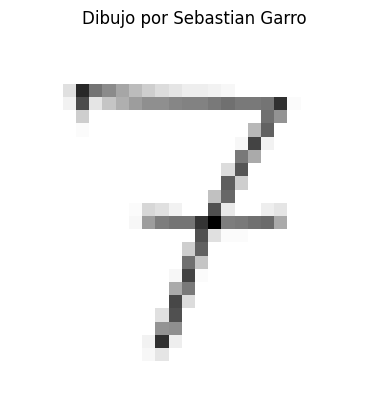

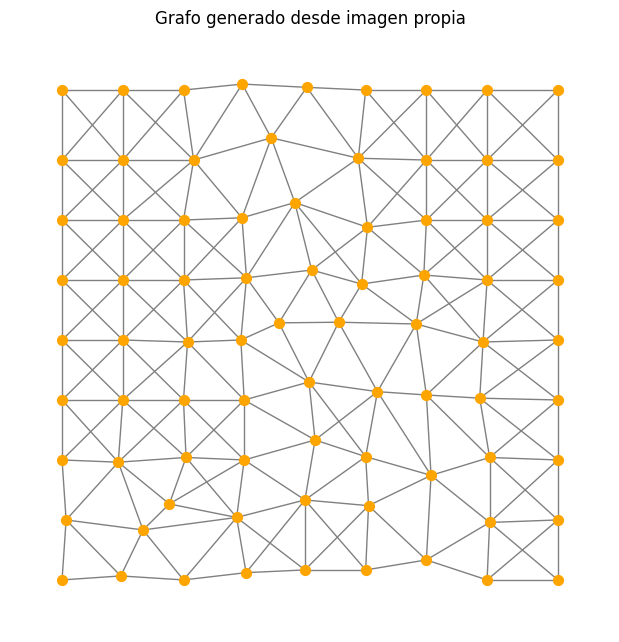

Shape batch.x: torch.Size([79, 1])
x0 shape después de concatenar: torch.Size([79, 3])
Predicción del modelo: 4 (confianza: 96.45%)


In [231]:
data, imagen_original = convertir_imagen_a_grafo("Imagen_Joel.jpg")
print("Shape de data.x antes de batch:", data.x.shape)  # Debe ser [N, 1]

# --- Visualizar imagen ---
plt.imshow(imagen_original, cmap='gray')
plt.title("Dibujo por Sebastian Garro")
plt.axis('off')
plt.show()

# --- Visualizar grafo ---
G = to_networkx(data, to_undirected=True)
pos_dict = {i: data.pos[i].numpy() for i in range(data.num_nodes)}
plt.figure(figsize=(6, 6))
nx.draw(G, pos=pos_dict, node_size=50, node_color='orange', edge_color='gray')
plt.title("Grafo generado desde imagen propia")
plt.axis('off')
plt.show()

# --- Preparar batch e inferencia ---
batch = Batch.from_data_list([data])
print("Shape batch.x:", batch.x.shape)  # [N, 1]

model = GNNImageClassificator(hidden_dim=152)
model.load_state_dict(torch.load("modelo_gnn_mnist.pth"))
model.eval()

with torch.no_grad():
    output = model(batch)
    probs = F.softmax(output, dim=1)[0]
    pred = probs.argmax().item()
    confianza = probs[pred].item() * 100

print(f"Predicción del modelo: {pred} (confianza: {confianza:.2f}%)")

Shape de data.x antes de batch: torch.Size([78, 1])


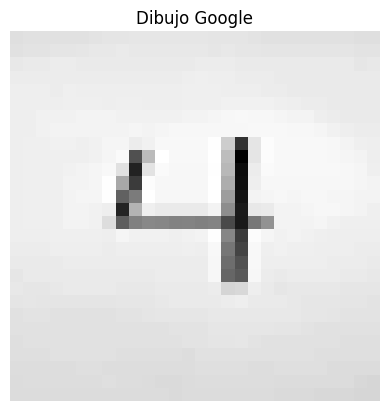

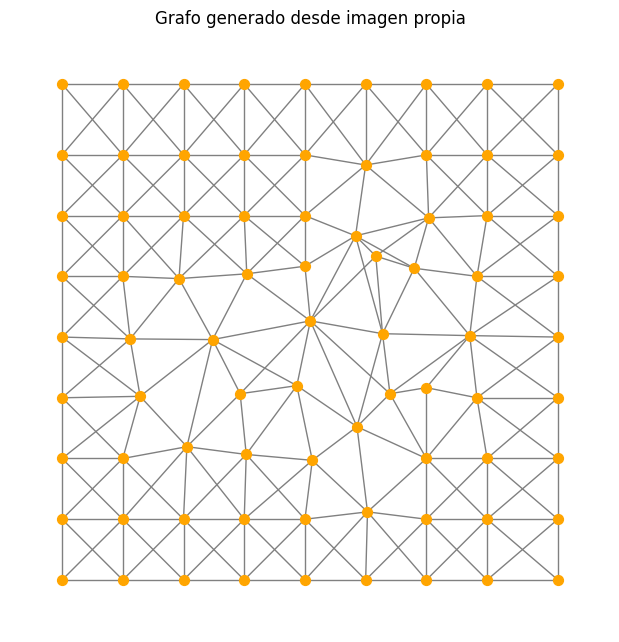

Shape batch.x: torch.Size([78, 1])
x0 shape después de concatenar: torch.Size([78, 3])
Predicción del modelo: 4 (confianza: 70.00%)


In [249]:
data, imagen_original = convertir_imagen_a_grafo("images.jpg")
print("Shape de data.x antes de batch:", data.x.shape)  # Debe ser [N, 1]

# --- Visualizar imagen ---
plt.imshow(imagen_original, cmap='gray')
plt.title("Dibujo Google")
plt.axis('off')
plt.show()

# --- Visualizar grafo ---
G = to_networkx(data, to_undirected=True)
pos_dict = {i: data.pos[i].numpy() for i in range(data.num_nodes)}
plt.figure(figsize=(6, 6))
nx.draw(G, pos=pos_dict, node_size=50, node_color='orange', edge_color='gray')
plt.title("Grafo generado desde imagen propia")
plt.axis('off')
plt.show()

# --- Preparar batch e inferencia ---
batch = Batch.from_data_list([data])
print("Shape batch.x:", batch.x.shape)  # [N, 1]

model = GNNImageClassificator(hidden_dim=152)
model.load_state_dict(torch.load("modelo_gnn_mnist.pth"))
model.eval()

with torch.no_grad():
    output = model(batch)
    probs = F.softmax(output, dim=1)[0]
    pred = probs.argmax().item()
    confianza = probs[pred].item() * 100

print(f"Predicción del modelo: {pred} (confianza: {confianza:.2f}%)")

Shape de data.x antes de batch: torch.Size([77, 1])


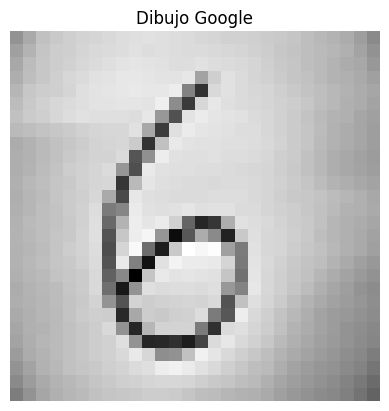

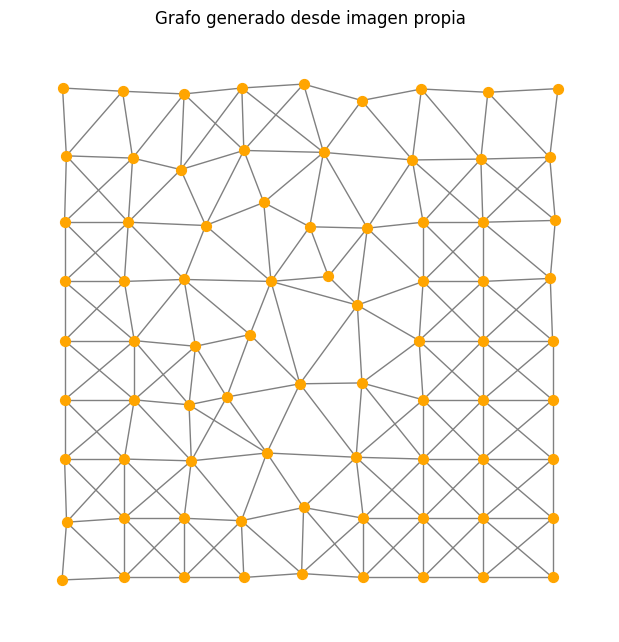

Shape batch.x: torch.Size([77, 1])
x0 shape después de concatenar: torch.Size([77, 3])
Predicción del modelo: 6 (confianza: 47.46%)


In [250]:
data, imagen_original = convertir_imagen_a_grafo("como_dibujar_el_numero_6_de_forma_original_5128_paso_1_600.jpg")
print("Shape de data.x antes de batch:", data.x.shape)  # Debe ser [N, 1]

# --- Visualizar imagen ---
plt.imshow(imagen_original, cmap='gray')
plt.title("Dibujo Google")
plt.axis('off')
plt.show()

# --- Visualizar grafo ---
G = to_networkx(data, to_undirected=True)
pos_dict = {i: data.pos[i].numpy() for i in range(data.num_nodes)}
plt.figure(figsize=(6, 6))
nx.draw(G, pos=pos_dict, node_size=50, node_color='orange', edge_color='gray')
plt.title("Grafo generado desde imagen propia")
plt.axis('off')
plt.show()

# --- Preparar batch e inferencia ---
batch = Batch.from_data_list([data])
print("Shape batch.x:", batch.x.shape)  # [N, 1]

model = GNNImageClassificator(hidden_dim=152)
model.load_state_dict(torch.load("modelo_gnn_mnist.pth"))
model.eval()

with torch.no_grad():
    output = model(batch)
    probs = F.softmax(output, dim=1)[0]
    pred = probs.argmax().item()
    confianza = probs[pred].item() * 100

print(f"Predicción del modelo: {pred} (confianza: {confianza:.2f}%)")

Shape de data.x antes de batch: torch.Size([77, 1])


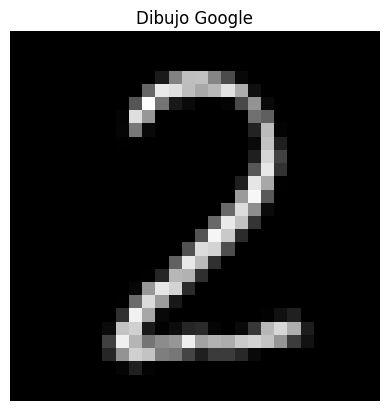

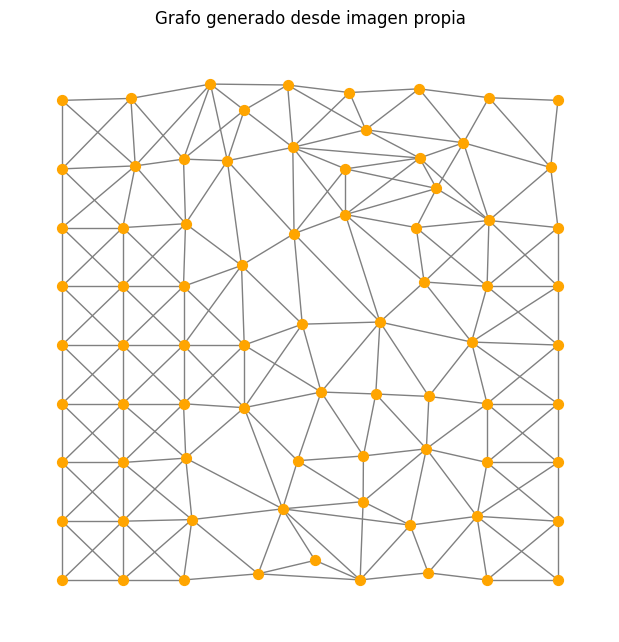

Shape batch.x: torch.Size([77, 1])
x0 shape después de concatenar: torch.Size([77, 3])
Predicción del modelo: 2 (confianza: 53.49%)


In [251]:
data, imagen_original = convertir_imagen_a_grafo("14794295-two-chalk-numbers-over-black-background.jpg")
print("Shape de data.x antes de batch:", data.x.shape)  # Debe ser [N, 1]

# --- Visualizar imagen ---
plt.imshow(imagen_original, cmap='gray')
plt.title("Dibujo Google")
plt.axis('off')
plt.show()

# --- Visualizar grafo ---
G = to_networkx(data, to_undirected=True)
pos_dict = {i: data.pos[i].numpy() for i in range(data.num_nodes)}
plt.figure(figsize=(6, 6))
nx.draw(G, pos=pos_dict, node_size=50, node_color='orange', edge_color='gray')
plt.title("Grafo generado desde imagen propia")
plt.axis('off')
plt.show()

# --- Preparar batch e inferencia ---
batch = Batch.from_data_list([data])
print("Shape batch.x:", batch.x.shape)  # [N, 1]

model = GNNImageClassificator(hidden_dim=152)
model.load_state_dict(torch.load("modelo_gnn_mnist.pth"))
model.eval()

with torch.no_grad():
    output = model(batch)
    probs = F.softmax(output, dim=1)[0]
    pred = probs.argmax().item()
    confianza = probs[pred].item() * 100

print(f"Predicción del modelo: {pred} (confianza: {confianza:.2f}%)")

### Ultima prueba

Shape de data.x antes de batch: torch.Size([71, 1])


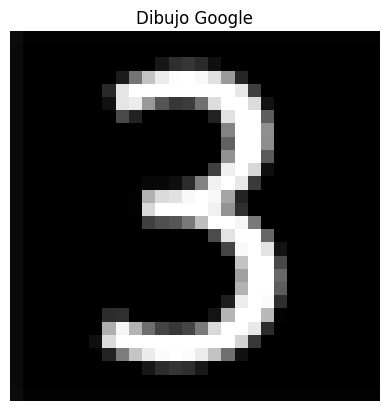

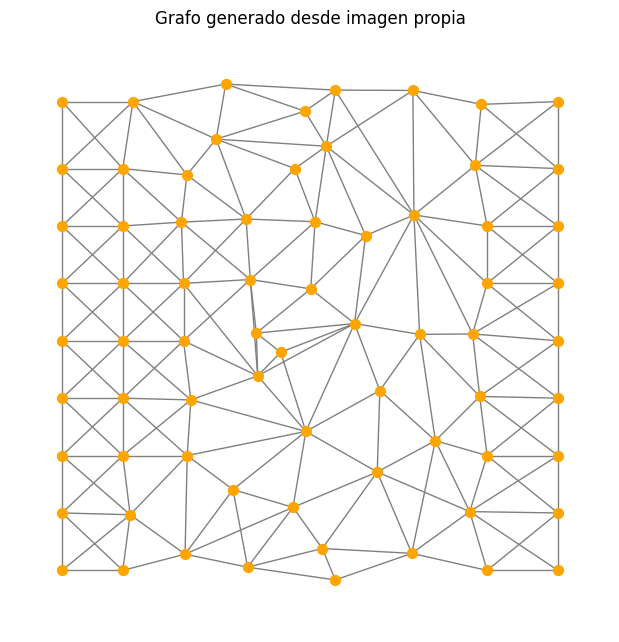

Shape batch.x: torch.Size([71, 1])
x0 shape después de concatenar: torch.Size([71, 3])
Predicción del modelo: 2 (confianza: 60.71%)


In [252]:
data, imagen_original = convertir_imagen_a_grafo("573aea4cdb1ce4f872108d51d473a5b0.jpg")
print("Shape de data.x antes de batch:", data.x.shape)  # Debe ser [N, 1]

# --- Visualizar imagen ---
plt.imshow(imagen_original, cmap='gray')
plt.title("Dibujo Google")
plt.axis('off')
plt.show()

# --- Visualizar grafo ---
G = to_networkx(data, to_undirected=True)
pos_dict = {i: data.pos[i].numpy() for i in range(data.num_nodes)}
plt.figure(figsize=(6, 6))
nx.draw(G, pos=pos_dict, node_size=50, node_color='orange', edge_color='gray')
plt.title("Grafo generado desde imagen propia")
plt.axis('off')
plt.show()

# --- Preparar batch e inferencia ---
batch = Batch.from_data_list([data])
print("Shape batch.x:", batch.x.shape)  # [N, 1]

model = GNNImageClassificator(hidden_dim=152)
model.load_state_dict(torch.load("modelo_gnn_mnist.pth"))
model.eval()

with torch.no_grad():
    output = model(batch)
    probs = F.softmax(output, dim=1)[0]
    pred = probs.argmax().item()
    confianza = probs[pred].item() * 100

print(f"Predicción del modelo: {pred} (confianza: {confianza:.2f}%)")

### Recomendaria mejor usar un fondo negro y el número en blanco o algo que resalte ya que es más preciso

### Observemos que a la hora de hacer predicciones, puede llegar a predecir unas y otras no, hablando con el profesor en las clases, me dijo de probar el 7, ya que esta es muy común que el modelo la confunda con un 4, donde vemos que se aplica también a este modelo, aparte de esto, las predicciones del porcentaje que se obtiene son muy incosistentes, puede ser debido a como esta el dibujo o como lo analiza nuestro metódo, como puse arriba recomendaria que fuera negro el fondo y un color tono claro del número para que se pueda indetificar mejor, como por ejemplo los números que se sacaron del data de MINST para prueba. 

### Ya como conclusión quiero decir que aprendi mucho de este mundo de modelos tanto CNN ( donde al final no era el proposito de investigación) y GNNs, la cual es bueno para poder practicar cosas que son funcionales al exterior de nuestro mundo la cual es la U, agradezco su tiempo de lectura y dejo abajo las referencias de donde saco toda la información, debido a que pruebas GNNs fueron más dificiles de ver documentadas con codigo abierto para poder entender ciertas cosas de estos.

## Referencias utilizadas para el desarrollo del modelo y la investigación:

### Nick Nochnack. (s.f.). Graph Neural Networks con PyTorch Geometric.
### GitHub repository: https://github.com/nicknochnack

# Anton Cherepkov. (s.f.). 
#### GitHub repository: https://github.com/Anton-Cherepkov

### DataCamp. (s.f.). A Comprehensive Introduction to Graph Neural Networks (GNNs).
### Tutorial disponible en: https://www.datacamp.com/es/tutorial/comprehensive-introduction-graph-neural-networks-gnns-tutorial

### Efraín Retana Segura – Universidad de Costa Rica. (s.f.).
### Proyecto "cifar-10-gnn-classification" en Weights & Biases:
### https://wandb.ai/efrain-retana-segura-universidad-de-costa-rica/cifar-10-gnn-classification?nw=nwuserefrainretanasegura

### IOPscience. (2021). Image classification using graph neural networks: an application to CIFAR-10.
### Journal of Physics: Conference Series, Vol. 1871.
### https://iopscience.iop.org/article/10.1088/1742-6596/1871/1/012071/pdf

### ChatGPT (OpenAI) y Claude (Anthropic).
### Asistentes de inteligencia artificial utilizados para generación de código y explicación de conceptos técnicos.
